# The Mandatory Exam Assignment. Autumn 2022. 

## Exercise 1

The original code:

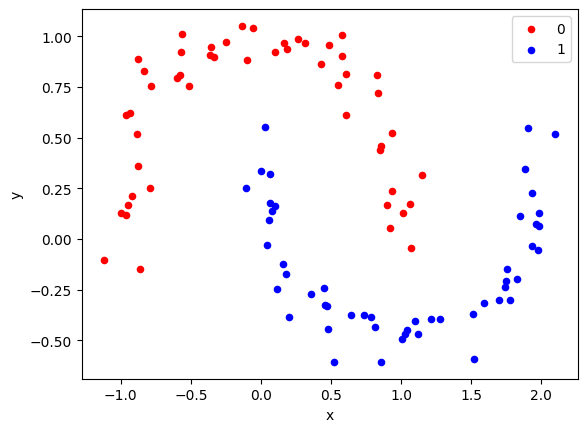

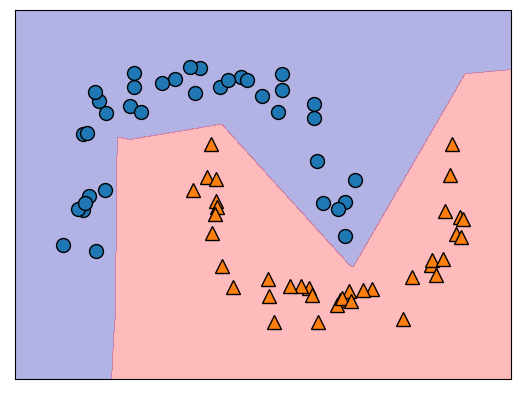

In [383]:
# -*- coding: utf-8 -*-
"""
Created on Mon December 9 15:16:37 2018

@author: sila
"""

from sklearn.datasets import make_moons;
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np

from matplotlib.colors import ListedColormap, colorConverter

cm3 = ListedColormap(['#0000aa', '#ff2020', '#50ff50'])
cm2 = ListedColormap(['#0000aa', '#ff2020'])

from matplotlib import pyplot
from pandas import DataFrame

def plot_2d_separator(classifier, X, fill=False, ax=None, eps=None, alpha=1,
                      cm=cm2, linewidth=None, threshold=None,
                      linestyle="solid"):
    # binary?
    if eps is None:
        eps = X.std() / 2.

    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        decision_values = classifier.decision_function(X_grid)
        levels = [0] if threshold is None else [threshold]
        fill_levels = [decision_values.min()] + levels + [
            decision_values.max()]
    except AttributeError:
        # no decision_function
        decision_values = classifier.predict_proba(X_grid)[:, 1]
        levels = [.5] if threshold is None else [threshold]
        fill_levels = [0] + levels + [1]
    if fill:
        ax.contourf(X1, X2, decision_values.reshape(X1.shape),
                    levels=fill_levels, alpha=alpha, cmap=cm)
    else:
        ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels,
                   colors="black", alpha=alpha, linewidths=linewidth,
                   linestyles=linestyle, zorder=5)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())


def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None,
                     labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None):
    """Adaption of matplotlib.pyplot.scatter to plot classes or clusters.
    Parameters
    ----------
    x1 : nd-array
        input data, first axis
    x2 : nd-array
        input data, second axis
    y : nd-array
        input data, discrete labels
    cmap : colormap
        Colormap to use.
    markers : list of string
        List of markers to use, or None (which defaults to 'o').
    s : int or float
        Size of the marker
    padding : float
        Fraction of the dataset range to use for padding the axes.
    alpha : float
        Alpha value for all points.
    """
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unique_y = np.unique(y)

    if markers is None:
        markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(markers) == 1:
        markers = markers * len(unique_y)

    if labels is None:
        labels = unique_y

    # lines in the matplotlib sense, not actual lines
    lines = []

    current_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unique_y, current_cycler())):
        mask = y == yy
        # if c is none, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # use light edge for dark markers
        if np.mean(colorConverter.to_rgb(color)) < .4:
            markeredgecolor = "grey"
        else:
            markeredgecolor = "black"

        lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
                             label=labels[i], alpha=alpha, c=color,
                             markeredgewidth=markeredgewidth,
                             markeredgecolor=markeredgecolor)[0])

    if padding != 0:
        pad1 = x1.std() * padding
        pad2 = x2.std() * padding
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lines


# generate 2d classification dataset
X, y = make_moons(n_samples=100, noise=0.1, random_state=12)
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])

pyplot.show()


from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

mlp = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=[10, 10])
mlp.fit(X_train, y_train)

plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

pyplot.show()

### A)

Running the code like above, shows two plots. The first plot shows all the moons, colored by their cluster. The second plot shows the decision boundary of the model. From this second plot, we can see it does a decent job at predicting the correct cluster, but at the same time, it does not fully capture the shape of the dataset.

There are a number of hyperparameters we can tweak in order to improve the accuracy of the model. We will try the following:
- Number of hidden layers and the density
- Regularization term

Much of the code is about plotting. The interesting part is this:
```python
mlp = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=[10, 10])
```

We can make the following changes:

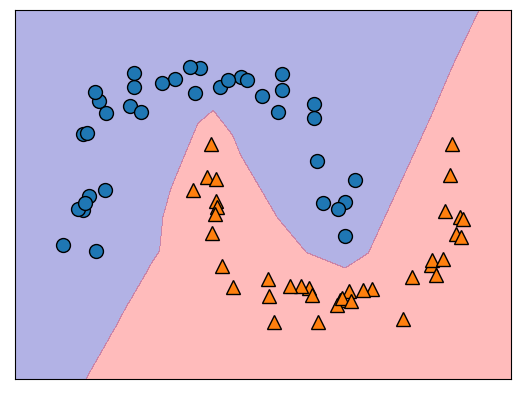

In [384]:
# Deeper and wider network
hidden_layers = [20, 20, 20]

mlp = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=hidden_layers)
mlp.fit(X_train, y_train)

plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

pyplot.show()

A wider and deeper hidden layer allow the model to create a more complex prediction function. The plot shows that the model does a better job at capturing the shape of the dataset.

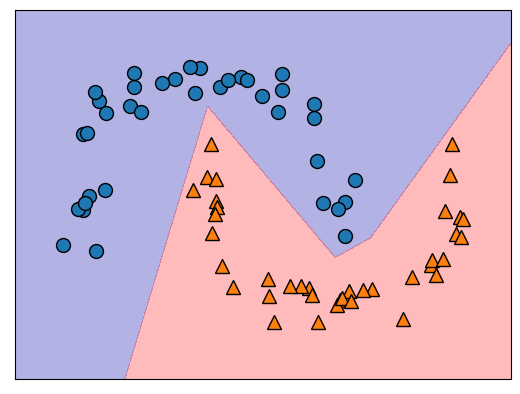

In [385]:
# Thinner and more shallow network
hidden_layers = [5]

mlp = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=hidden_layers)
mlp.fit(X_train, y_train)

plot_2d_separator(mlp, X_train, fill=True, alpha=.3)
discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

pyplot.show()

Here we see that it is possible to approximate a good solution with a very small network. A single hidden layer with 5 nodes. 5 seems to work really well on the dataset, while `5 < x < 10` gives weird results. I do not know why 5 captures the data so well. A network of 5 nodes still gives a spiky curve compared to the deeper net. 
From these plots, we can conclude the deeper net provides a better solution. A deeper is less performant that a swallow net, in terms of speed. Accuracy is more important than speed in this case.

We can also adjust the regularization term.

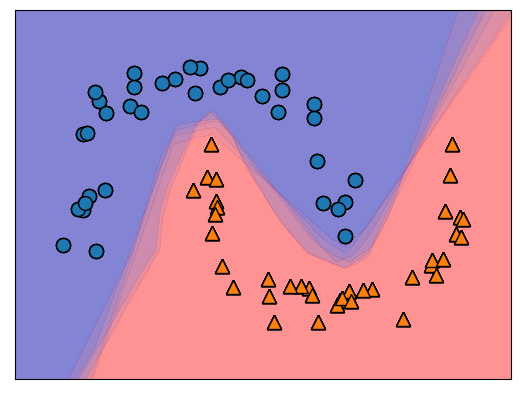

In [386]:
hidden_layers = [20, 20, 20]
for alpha in (1, 0.5, 0.1, 0.01, 0.001, 0.0001):
    mlp = MLPClassifier(solver='lbfgs', random_state=0, hidden_layer_sizes=hidden_layers, alpha=alpha, max_iter=10000)
    mlp.fit(X_train, y_train)

    plot_2d_separator(mlp, X_train, fill=True, alpha=.1)
    discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

    pyplot.plot()


This is a plot of 6 different regularization values: 

```python
(1, 0.5, 0.1, 0.01, 0.001, 0.0001)
```

This plot can be a bit hard to parse, but in generel, a higher regularization term creates a smoother boundary. This means that in this case, the model is generalizing better.

### B)

Different models might work well, so lets try them out.

#### Logistic regression

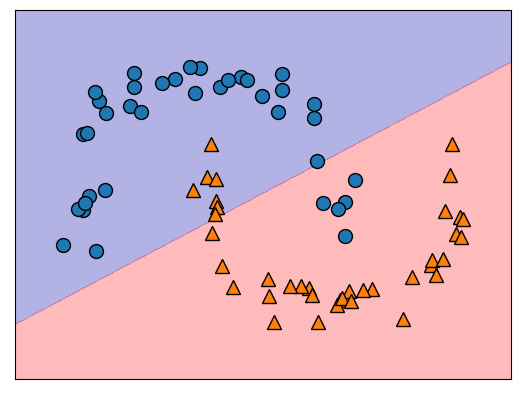

In [387]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
logistic.fit(X_train, y_train)

plot_2d_separator(logistic, X_train, fill=True, alpha=.3)
discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

pyplot.show()

As we can see, Logistic Regression is a linear classification model. To fit the data we will need to add polynomials.

In [388]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score

# Linear
logistic = LogisticRegression()
logistic.fit(X_train, y_train)
print('Linear: ', accuracy_score(y_test, logistic.predict(X_test)))

# Polynomial
logistic = LogisticRegression()
poly = PolynomialFeatures(degree = 3, interaction_only=False, include_bias=False)
X_poly = poly.fit_transform(X_train)
logistic.fit(X_poly, y_train)
print('Polynomial: ', accuracy_score(y_test, logistic.predict(poly.transform(X_test))))

Linear:  0.88
Polynomial:  0.96


sklearn provides a function for transforming the data into a polynomial set. Plotting this does not work with the provided functions, but using the accuracy score, we can see it performs better.
A third degree polynomial creates a curve that goes up, then down, then up again, which reflects the shape of the dataset.

#### K means

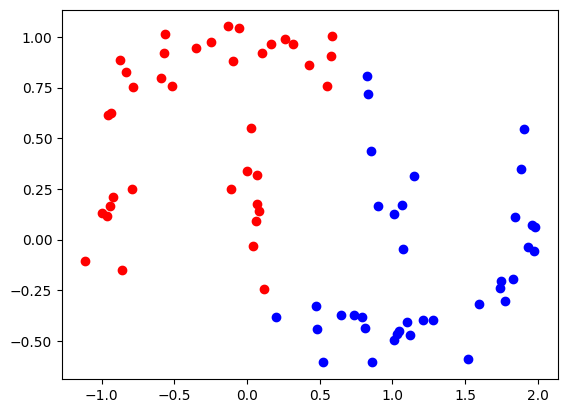

In [389]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
y_pred = kmeans.fit(X_train)
labels = y_pred.labels_

blues = X_train[labels == 0]
reds = X_train[labels == 1]

plt.scatter(blues[:,0] , blues[:,1] , color = 'blue')
plt.scatter(reds[:,0] , reds[:,1] ,color = 'red')
plt.show()

KMeans splits the dataset linearly. We tell KMeans to find two clusters, since that is the number of classes we have. 
KMeans is not the best solution here.

#### Decisions Tree and Random Forest

Tree


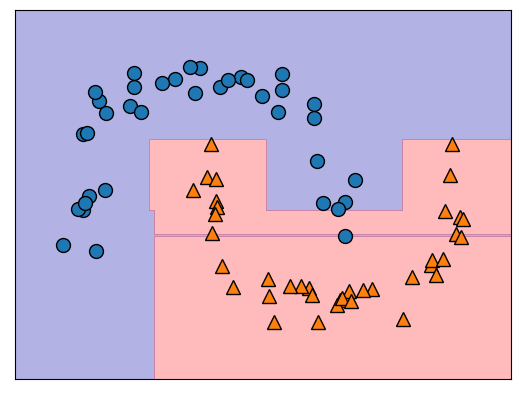

Forest


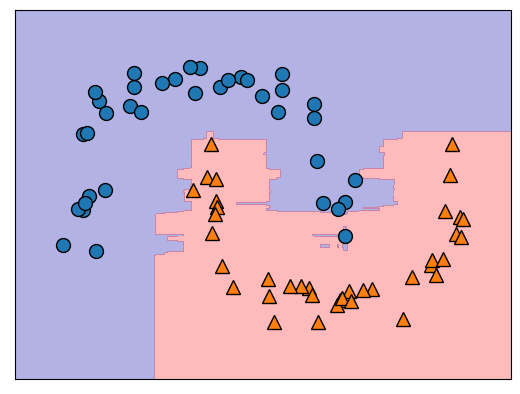

In [390]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Tree
print('Tree')
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_train, y_train)

plot_2d_separator(tree, X_train, fill=True, alpha=.3)
discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

pyplot.show()

# Forest
print('Forest')
forest = RandomForestClassifier(max_depth=5, n_estimators=100)
forest.fit(X_train, y_train)

plot_2d_separator(forest, X_train, fill=True, alpha=.3)
discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

pyplot.show()

We can see that the forest gets a better score on the training set, but it looks like it is overfitting the data. This result is poorly than I expected, and not close to compete with the neural net.

#### SVM

linear


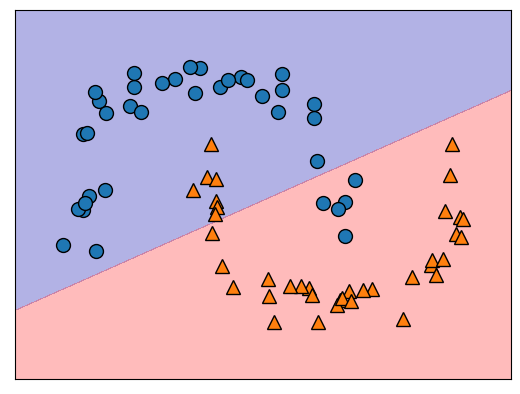

poly


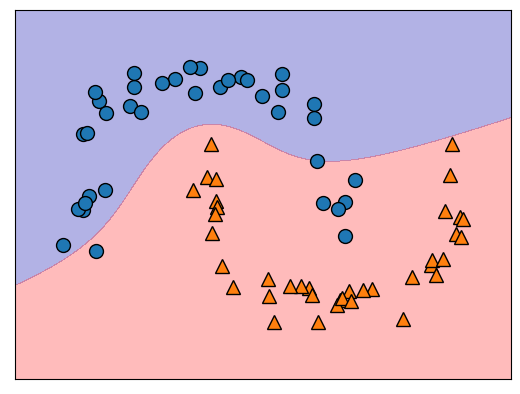

rbf


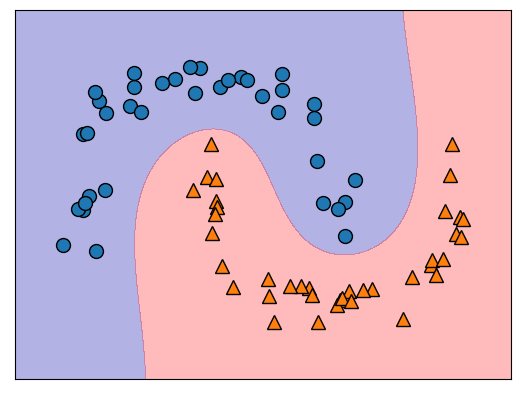

sigmoid


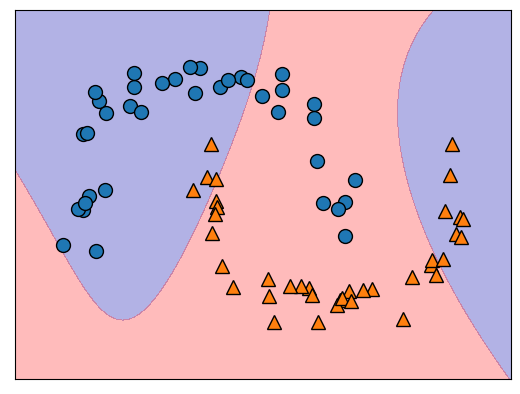

linear:  0.88
poly:  0.92
rbf:  1.0
sigmoid:  0.56


In [391]:
from sklearn.svm import SVC

results = []
for kernel in ('linear', 'poly', 'rbf', 'sigmoid'):
    print(kernel)
    svc = SVC(kernel=kernel, degree=3, C=10)
    svc.fit(X_train, y_train)
    
    results.append((kernel, accuracy_score(y_test, svc.predict(X_test))))
    
    plot_2d_separator(svc, X_train, fill=True, alpha=.3)
    discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
    
    pyplot.show()

for (k, a) in results:
    print(k + ": ", a)
    

Here is a plot and an accuracy score for each different kernel. RBF does the best, followed by poly. Changing the degrees from 3 to 5 does not have a big impact, but regularizing with C improves RBF nicely. Increasing C makes the line have more distance to the clusters.

### C)

The original code:

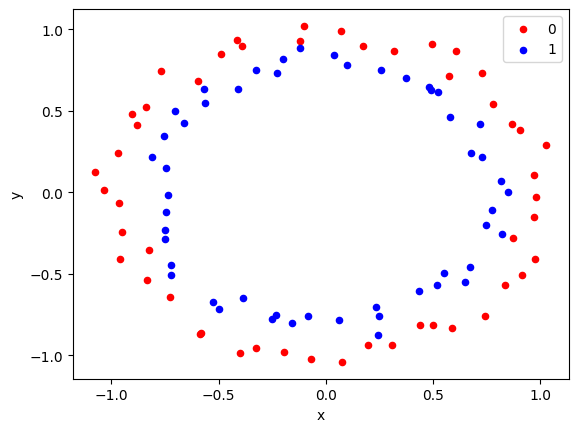

In [392]:
# -*- coding: utf-8 -*-
"""
Created on Wed Apr 14 11:23:02 2018

@author: sila
"""

from sklearn.datasets import make_circles;
import matplotlib.pyplot as plt

from matplotlib import pyplot
from pandas import DataFrame, Series
# generate 2d classification dataset
# generate 2d classification dataset
X, y = make_circles(n_samples=100, noise=0.05)
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

Trying different SVM kernels:

linear


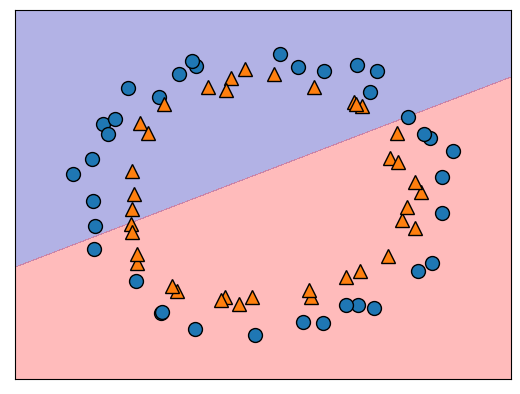

poly


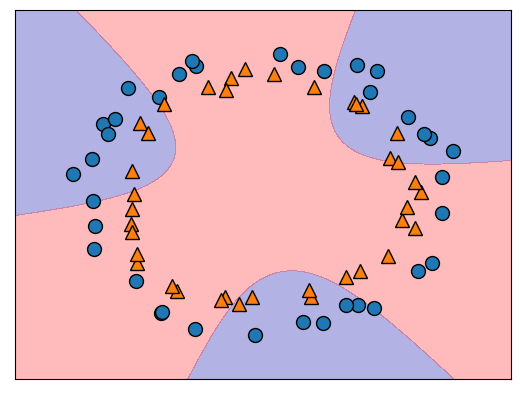

rbf


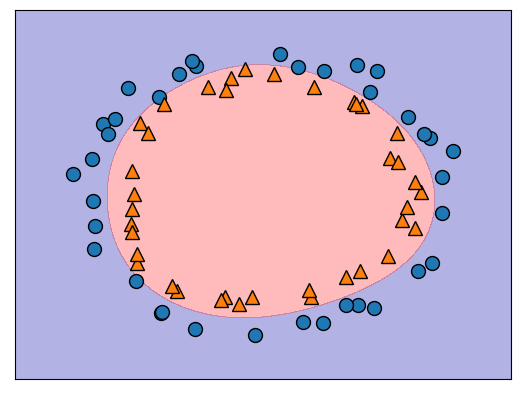

sigmoid


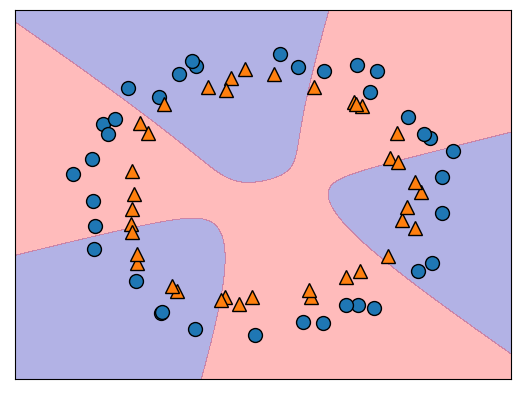

linear:  0.36
poly:  0.36
rbf:  0.88
sigmoid:  0.64


In [393]:

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

results = []
for kernel in ('linear', 'poly', 'rbf', 'sigmoid'):
    print(kernel)
    svc = SVC(kernel=kernel, degree=3, C=10)
    svc.fit(X_train, y_train)
    
    results.append((kernel, accuracy_score(y_test, svc.predict(X_test))))
    
    plot_2d_separator(svc, X_train, fill=True, alpha=.3)
    discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
    
    pyplot.show()

for (k, a) in results:
    print(k + ": ", a)

Here we see Gaussian (rbf) does the best again, with an accuracy of 92%.

### Conclusion

For "make moons", an SVM with rbf kernel with some regularization, does the best job of fitting the data.
If using a neural network, a semi-deep net, with some regularization provides the best result.

For "make circles", an SVM with rbf kernel with some regularization, again does the best job of fitting the data.

## Exercise 2

### A)

This is a supervised classification problem. It is supervised because we know the labels (Survied or not), and a classification problem because we are trying to predict which class (1 or 0), not a value.
The dataset consists of 11 (including name and passengerId) features and 1 label. Survival is the y-label, while all the other data are features.

### B)

To clean the dataset, it is possible that some features do not correlate with the label at all. That is, it has no impact and can safely be removed. 
Candidates for removal:
- Ticket: It is assumed these are distributed randomly
- PassengerId: It is assumed these are distributed randomly
- Cabin is missing a lot of data, so it is only of the data can be restored accurately that it is useful
- Fare looks to be in different currency, or simple wrong. People embarking in the same city can have differences up to a hundred thousand.
- Embarked: Where someone joined the journey should not matter, but it might correlate with class and cabin. The ship might have filled up cabins as it collected people, meaning that people from the same city have cabins close to each other. In the case that cabin is relevant, so might embarked be.
  - Embarked is a candidate, since it should not matter. If we know the cabin, we do not need to know the city, but if we do not know the cabin, we might be able to find out from the city. This is only if the assumption of how they fill up the ship is correct. This should be investigated further.
- Name: Name should not have an impact on whether or not you survived, though name will probably correlate with class and sex. And for females, it specifies wether they are married or not (mrs / miss)
  - Name is a candidate, but I wouldn't remove it without further investigation.
  - Name as it stands contains about 800 unique values, which means it does not correlate by definition. However, Whether it contains "miss", "mrs", or "mr" might affect survival rate. Futhermore, if it contained titles such as "Lord" or "Dr" then it would be even more useful.

#### Checking for correlations



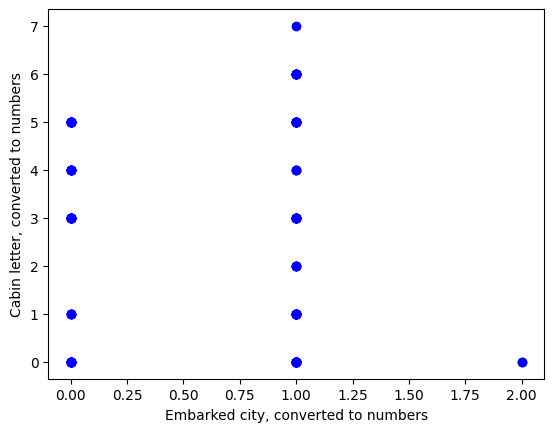

In [394]:
import pandas

df = pandas.read_csv("titanic_800.csv")
df.dropna(axis=0, inplace=True)
(embarked, _) = df['Embarked'].factorize()
cabin_area = df['Cabin'].apply(lambda x: x[0]) # Only take the letter from the Cabin. I assume that is the area of the cabin.

(cabin, _) = cabin_area.factorize()

pyplot.scatter(embarked, cabin, color = 'blue')
pyplot.xlabel('Embarked city, converted to numbers')
pyplot.ylabel('Cabin letter, converted to numbers')
pyplot.show()

Here we see how Embarked correlates with Cabin. If there were a strong correlation, we would expect to see the first city to take up a subset of the cabin areas, while the nexet city would take up a different subset.
This does not seem to be the case.

Let see how cabin correlates with survival, to see if it is a feature we should keep.

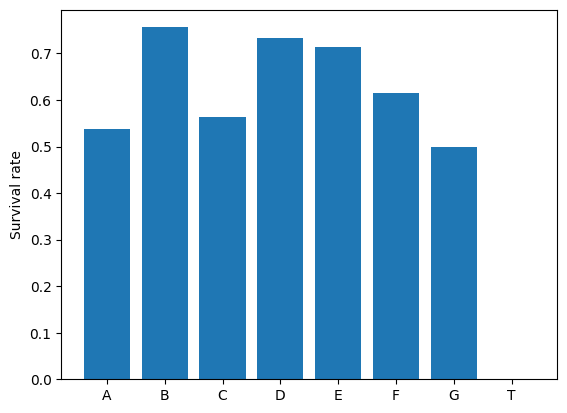

In [395]:
df = pandas.read_csv("titanic_800.csv")

df = df[df['Cabin'].notna()]

cabin_area = df['Cabin'].apply(lambda x: x[0])
(_, cabins) = cabin_area.factorize()
cabins = cabins.sort_values()

survival_rates = []
for area in cabins:
    survival_rates.append(df.loc[cabin_area == area, 'Survived'].mean())

pyplot.bar(cabins, survival_rates)
pyplot.ylabel('Survival rate')
pyplot.show()

Looking at Cabin, it is missing a lot of data. There seems to be a bit of a correlation, but given the tiny amount of data, I argue it is due to sampling noise. I will therefore discard the cabin.

Then Embarked with survival.

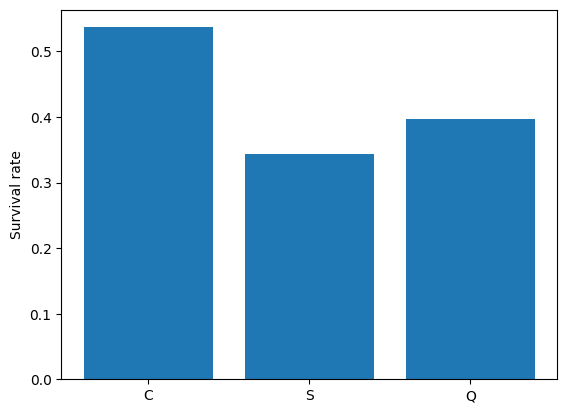

In [396]:
df = pandas.read_csv("titanic_800.csv")

df = df[['Embarked', 'Survived']].dropna(axis=0)

survival_rates = []
for embarked in ['C', 'S', 'Q']:
    survival_rates.append(df.loc[df['Embarked'] == embarked, 'Survived'].mean())

pyplot.bar(['C', 'S', 'Q'], survival_rates)
pyplot.ylabel('Survival rate')
pyplot.show()

It is difficult to say why embarked seems to correlate, but I will keep it in for now.

Lets look at class and age.

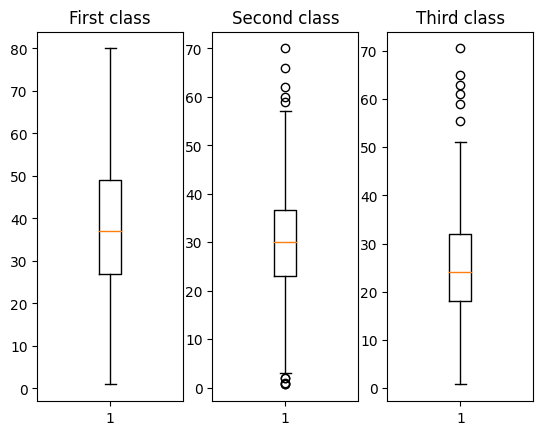

In [397]:
df = pandas.read_csv("titanic_800.csv")

df = df[['Pclass', 'Age']].dropna(axis=0)

fig, axs = plt.subplots(1, 3)
axs[0].boxplot(df.loc[df['Pclass'] == 1, 'Age'])
axs[0].set_title('First class')
axs[1].boxplot(df.loc[df['Pclass'] == 2, 'Age'])
axs[1].set_title('Second class')
axs[2].boxplot(df.loc[df['Pclass'] == 3, 'Age'])
axs[2].set_title('Third class')
pyplot.show()

This shows us that the average age is greater among class 1, while class 3 has some outliers.

Lets get a base-survival rate.

In [398]:
df = pandas.read_csv("titanic_800.csv")
base_survival_rate = df['Survived'].mean()
print('Base survival rate: ', base_survival_rate)

Base survival rate:  0.385


Lets see how Pclass correlates with survival.

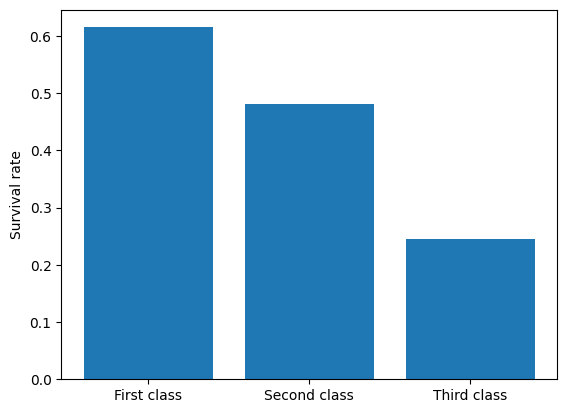

In [399]:
df = pandas.read_csv("titanic_800.csv")

df = df[['Pclass', 'Survived']].dropna(axis=0)

survival_rates = []
for c in (1, 2, 3):
    survival_rates.append(df.loc[df['Pclass'] == c, 'Survived'].mean())

pyplot.bar(['First class','Second class', 'Third class'], survival_rates)
pyplot.ylabel('Survival rate')
pyplot.show()

We can see, as one might suspect, socialeconomic class plays a significant role in survival. Lets just have a look at sex as well.

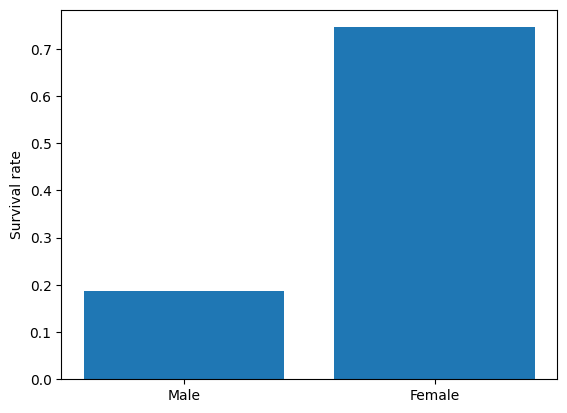

In [400]:
df = pandas.read_csv("titanic_800.csv")

df = df[['Sex', 'Survived']].dropna(axis=0)

survival_rates = []
for sex in ('male', 'female'):
    survival_rates.append(df.loc[df['Sex'] == sex, 'Survived'].mean())

pyplot.bar(['Male','Female'], survival_rates)
pyplot.ylabel('Survival rate')
pyplot.show()

Again, we see a very big correlation.

Lets see how the name can correlate with survival.

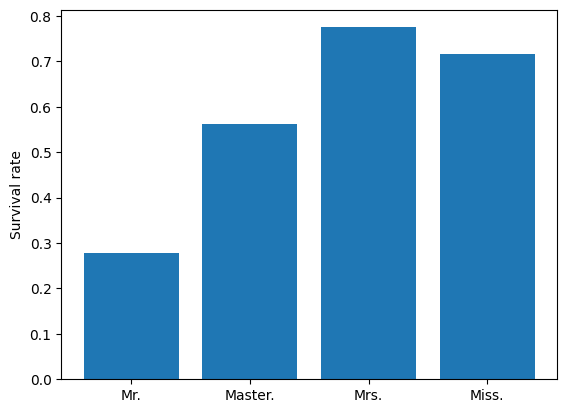

In [401]:
df = pandas.read_csv("titanic_800.csv")

df = df[['Name', 'Survived']].dropna(axis=0)

survival_rates = []
for title in ('Mr.', 'Master.', 'Mrs.', 'Miss.'):
    survival_rates.append(df.loc[df['Name'].str.contains(title), 'Survived'].mean())

pyplot.bar(['Mr.', 'Master.', 'Mrs.', 'Miss.'], survival_rates)
pyplot.ylabel('Survival rate')
pyplot.show()

Here we can see that it is possible to get even better data than the sex. A married woman is more likely to survive than a non-married woman, and a Master is more likely than a Mr.

#### Cleaning the data

Now that we know a bit more about the data, lets start cleaning the it.

In [402]:
df = pandas.read_csv("titanic_800.csv")

Lets remove Ticket and PassengerId, Cabin, Fare, Embarked and set Survived as the label.

In [403]:
X = df.drop(['Ticket', 'PassengerId', 'Cabin', 'Fare', 'Embarked', 'Survived'], axis=1)
y = df['Survived']

Lets convert non-numerical values to numbers.

In [404]:
# Mr == 1
# Mrs == 2
# Miss == 3
# Master == 4
X['Name'] = X['Name'].apply(lambda x: 1 if "Mr." in x else 2 if "Mrs." in x else 3 if "Miss." in x else 4)

X['Sex'] = X['Sex'].factorize()[0]

Now, we also need to convert cabins to numbers, but first, we must do something about the missing data.

#### Missing data

There are a few options for filling in missing data. The most obvious is to insert the mean into every missing entry. Titanic has both children and grandparents on board, so in case age is relevant, the mean does a poor job. Lets dig deeper into the data.

Lets start by looking at a correlation matrix.

In [405]:
corr = X.dropna(axis=0)
print(corr.corr(numeric_only=True))

          Pclass      Name       Sex       Age     SibSp     Parch
Pclass  1.000000 -0.126846 -0.141398 -0.372172  0.067624  0.025052
Name   -0.126846  1.000000  0.614115 -0.291828  0.299984  0.253176
Sex    -0.141398  0.614115  1.000000 -0.119757  0.105639  0.244957
Age    -0.372172 -0.291828 -0.119757  1.000000 -0.306498 -0.182402
SibSp   0.067624  0.299984  0.105639 -0.306498  1.000000  0.385550
Parch   0.025052  0.253176  0.244957 -0.182402  0.385550  1.000000


This gives us a correlation of all numeric values, so lets have a look at Age.

We can see that Age correlates with Pclass, Name and Parch. We already looked at Pclass, and Name makes sense, since "Miss." and "Mrs." indicates an age. We can also see that Parch correlates which especially makes sense when it is 0, as that is someone traveling alone og with a spouse.

Lets transform the data to reflect this.

If there are no parents/children, and only one sibling/spouse, lets assume it is a married couple without children, instead of two siblings without parents.

In [406]:
X['AdultWithoutChildren'] = X.apply(lambda x: 1 if x['Parch'] == 0 and x['SibSp'] == 1 else 0.1, axis=1)

If there are no parents/children and no siblings/spouse they are traveling alone. 

In [407]:
X['TravelingAlone'] = X.apply(lambda x: 1 if x['Parch'] == 0 and x['SibSp'] == 0 else 0.1, axis=1)

If there are parents/children and more than one sibling/spouse, lets assume that it is parents and siblings, and not multiple spouses.

In [408]:
X['IsTravelingWithSiblings'] = X.apply(lambda x: 1 if x['Parch'] > 0 and x['SibSp'] > 1 else 0.1, axis=1)

If there are more than 2 parents/children, lets assume that it is children.

In [409]:
X['TravelingWithChildren'] = X.apply(lambda x: 1 if x['Parch'] > 2 else 0.1, axis=1)

Lets see if these new features correlates with age.

In [410]:
age = X.dropna(subset=['Age'])
age_mean = age['Age'].mean()
adult_without_children_mean = age['Age'][age['AdultWithoutChildren'] == 1].mean()
traveling_alone = age['Age'][age['TravelingAlone'] == 1].mean()
is_traveling_with_siblings = age['Age'][age['IsTravelingWithSiblings'] == 1].mean()
traveling_with_children = age['Age'][age['TravelingWithChildren'] == 1].mean()

print("Age mean: ", age_mean)
print("Adults without children mean: ", adult_without_children_mean)
print("Traveling alone mean: ", traveling_alone)
print("Traveling with siblings mean: ", is_traveling_with_siblings)
print("Traveling with children mean: ", traveling_with_children)

Age mean:  29.871145996860278
Adults without children mean:  32.322916666666664
Traveling alone mean:  32.332402234636874
Traveling with siblings mean:  10.036585365853659
Traveling with children mean:  40.0


This has a higher correlation than class. Lets use this new data predict age. One way to estimate how accurate this predicts age, is to replace 20% of the existing entries with their respective mean, and calculate the mean squared error.

In [411]:
from sklearn.metrics import mean_squared_error

age_X_train, age_X_test, age_y_train, age_y_test = train_test_split(age.drop('Age', axis=1), age['Age'], test_size=0.2, random_state=42)

def get_mean_age(a):
    if a['AdultWithoutChildren'] == 1:
        return 32.32
    if a['TravelingAlone'] == 1:
        return 32.33
    if a['IsTravelingWithSiblings'] == 1:
        return 10.03
    if a['TravelingWithChildren'] == 1:
        return 40.0
    return 29.87
    
age_y_pred_with_just_mean = age_X_test.apply(lambda x: 29.87, axis=1)
age_y_pred_with_categories = age_X_test.apply(lambda x: get_mean_age(x), axis=1)

print('Error using just the mean: ', mean_squared_error(age_y_test, age_y_pred_with_just_mean))
print('Error using the categories: ', mean_squared_error(age_y_test, age_y_pred_with_categories))

Error using just the mean:  182.3921734375
Error using the categories:  148.23103671875


Using the categories, the mean squared error is brought down quite a bit. This is only using 4 features though, so lets build a model that uses other relevant features, such as Title and Pclass.

In [412]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

age = X.dropna(subset=['Age'])

age_X = age.drop(columns=['Age'])
age_X = StandardScaler().fit_transform(age_X)
age_y = age['Age']

age_model = MLPRegressor(solver='adam', random_state=0, hidden_layer_sizes=[2, 2], max_iter=10000, alpha=5)

age_X_train, age_X_test, age_y_train, age_y_test = train_test_split(age_X, age_y, test_size=0.2, random_state=42)

age_model.fit(age_X_train, age_y_train)

errors = mean_squared_error(age_y_test, age_model.predict(age_X_test))

print('Errors: ', errors)

Errors:  109.50085816738638


To make sure the categories gives the desired insight, the network is trained both with and without. Using a simple shallow network gives a significant improvement, and a combination of categories and a network gives the best result. The regularization parameter has also been adjusted.

Lets populate the missing age data with the learned model.

In [413]:
model = age_model

X_scaled = StandardScaler().fit_transform(X.drop(columns=['Age']))
new_ages = DataFrame(model.predict(X_scaled), columns=['Age'])

X = X.fillna(new_ages)

print(X['Age'].mean())
print(X['Age'].shape)

29.64202732323125
(800,)


Now we have 800 entries with age, and we can see the mean hasn't changed much, which is what we want.

Now that the data is ready, lets scale it, split it and train it.

### Training the model

It is evident from the data, that there isn't a linear correlation with survival. A higher dimension classification model is needed. We'll try both an SVM and a neural network.

First, lets split the data. a 80/20 split is chosen as a decent default. 80/20 gives the model enough data to actually learn something, while still keeping a big enough sample for testing to prevent overfitting. Has we had 10000 entries, I might have used more data for testing. When choosing a model, it is important that we choose a supervised classification model. To choose the right model, trying different model and comparing them is easy enough. I have tried a few different, but my 3 main candidates are SVM, Random Forest and MLP.

In [414]:
X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

svm = SVC(kernel='poly')
svm.fit(X_train, y_train)
print('SVM: ', accuracy_score(y_test, svm.predict(X_test)))

rf = RandomForestClassifier(n_estimators=1000, max_depth=12, random_state=0)
rf.fit(X_train, y_train)
print('RF: ', accuracy_score(y_test, rf.predict(X_test)))

mlp = MLPClassifier(solver='adam', random_state=0, hidden_layer_sizes=[10, 10, 10], max_iter=10000, alpha=5)
mlp.fit(X_train, y_train)
print('MLP: ', accuracy_score(y_test, mlp.predict(X_test)))


SVM:  0.85625
RF:  0.8375
MLP:  0.83125


The accuracy of the SVM is a bit better than the MLP and Random Forest. Lets examine the SVM in depth.

In [415]:
from sklearn.metrics import confusion_matrix

predictions = rf.predict(X_test)
[[true_pos, false_pos], [false_neg, true_neg]] = confusion_matrix(y_test, predictions)

print('True positives: ', true_pos)
print('False positives: ', false_pos)
print('True negatives: ', true_neg)
print('False negatives: ', false_neg)
print('Accuracy: ', (true_pos + true_neg) / (false_pos + false_neg + true_pos + true_neg))
print('Precision: ', true_pos / (true_pos + false_pos))
print('Recall: ', true_pos / (true_pos + false_neg))

True positives:  89
False positives:  11
True negatives:  45
False negatives:  15
Accuracy:  0.8375
Precision:  0.89
Recall:  0.8557692307692307


The model is best at precision, that is, when it predicts that someone survived, we can be 91% sure that it is the case. It is worse at recall, that is, of all the people that survived, we only found 86.67%.

Lets experiment with the model, and see if a higher score is possible. To try out a lot of different combinations, a GridSearch is useful.

In [416]:

from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=SVC(), param_grid={'kernel': ('linear', 'poly', 'rbf', 'sigmoid'), 'degree': np.arange(1, 5), 'C': np.arange(1, 5)}, scoring='f1')
grid.fit(X_train, y_train)

print(grid.best_params_)

svm = grid.best_estimator_
svm.fit(X_train, y_train)
print('Accuracy: ', accuracy_score(y_test, svm.predict(X_test)))

{'C': 1, 'degree': 1, 'kernel': 'rbf'}
Accuracy:  0.8625


The grid search gives a very simple SVM as the best model. This only provides a slight improvement though.

Lets see if the alternative dataset is any better.


## Exercise 3

### A)

PCA and KMeans with the Iris dataset

Before PCA:  (150, 4)
After PCA:  (150, 2)


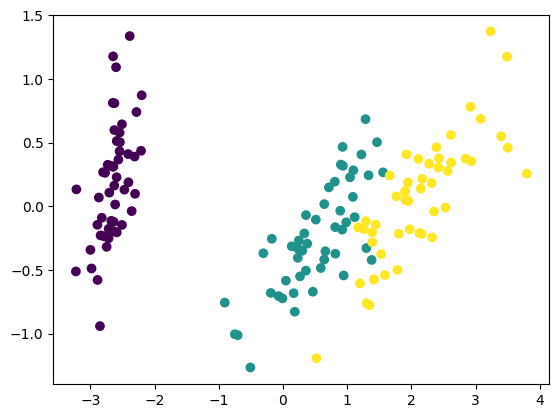

In [417]:

from sklearn.decomposition import PCA
from sklearn import datasets

iris_df = datasets.load_iris()
X, y = DataFrame(iris_df.data), Series(iris_df.target)

print('Before PCA: ', X.shape)

pca = PCA(2)
X_pca = pca.fit_transform(X)

print ('After PCA: ', X_pca.shape) 

plt.scatter(X_pca[:,0], X_pca[:,1],c=y)
plt.show()

This plots show the Iris dataset after applying a PCA(2) to it. Shrinking to just two dimensions.
It is pretty clear from the plot, that the PCA does a decent job at distinguish the different classes. However, the two classes to the right are pretty close together. Lets fit a KMeans to the data, and find 3 clusters.

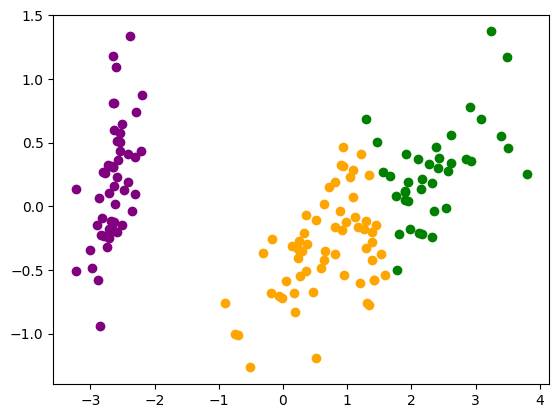

In [418]:
kmeans = KMeans(n_clusters=3)
y_pred = kmeans.fit(X_pca)
labels = y_pred.labels_

k1 = X_pca[labels == 0]
k2 = X_pca[labels == 1]
k3 = X_pca[labels == 2]

plt.scatter(k1[:,0], k1[:,1], color = 'orange')
plt.scatter(k2[:,0], k2[:,1], color = 'green')
plt.scatter(k3[:,0], k3[:,1], color = 'purple')
plt.show()



Unfortunately, KMeans fails to correctly identify the right boundary for clusters. It could easily find 2 clusters though.

PCA can work even better if the dataset is larger, this is because more data reveals larger correlations. PCA tries to determine which columns are most important, and given little data, this can be difficult.

### B)

Original code

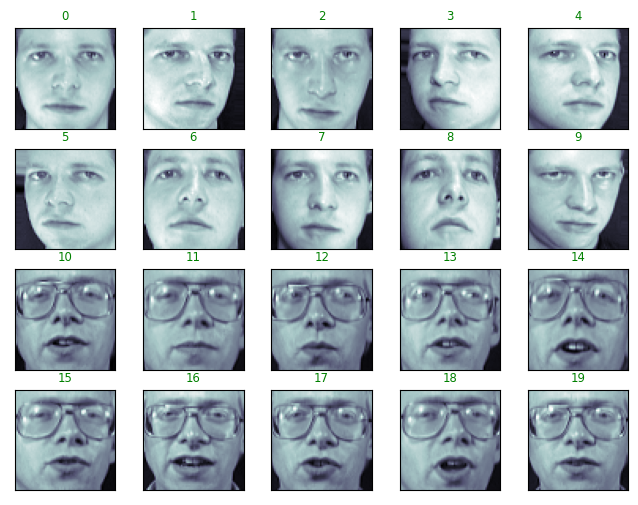

(300, 4096) (100, 4096)


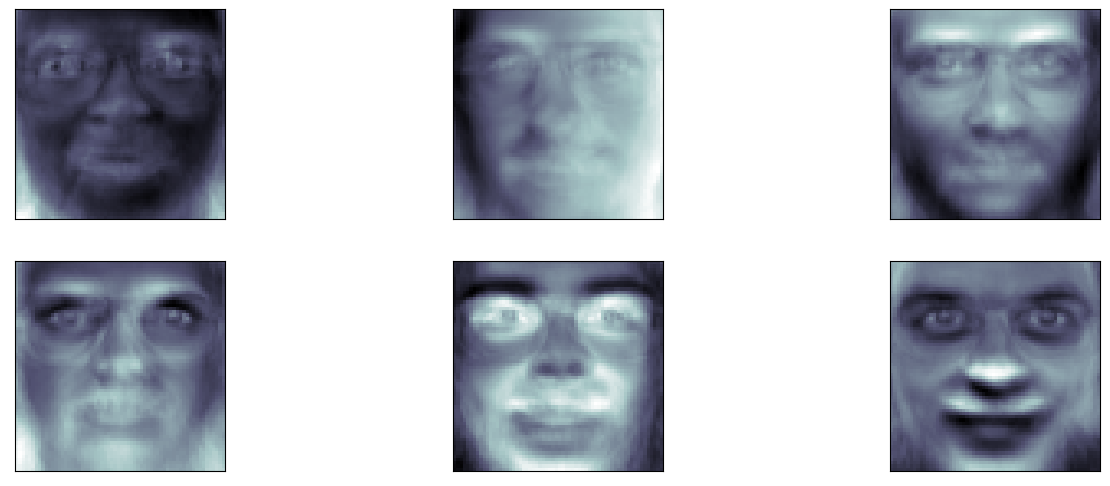

(300, 150)
(100, 150)


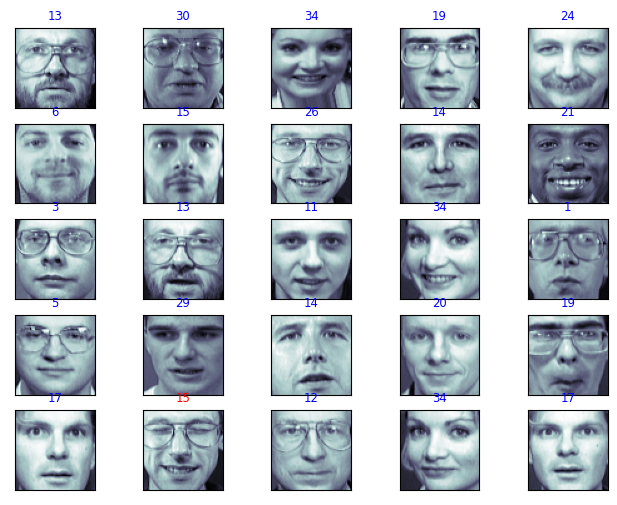

In [500]:
# -*- coding: utf-8 -*-
"""
Created on Mon December 9 10:41:37 2019

@author: sila
"""

from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn import datasets
from sklearn import svm
import numpy as np

faces = datasets.fetch_olivetti_faces()
faces.data.shape

from matplotlib import pyplot as plt

fig = plt.figure(figsize=(8, 6))

# The faces are already scaled to the same size.
# Lets plot the first 20 of these faces.
for i in range(20):
    ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(faces.images[i], cmap=plt.cm.bone)
    ax.set_title(i, fontsize='small', color='green')

plt.show()

# As usual, then lest split the dataset in a train and a test dataset.
X_train, X_test, y_train, y_test = train_test_split(faces.data,
                                                    faces.target, random_state=0)

print(X_train.shape, X_test.shape)

# Lets downscale the orginal pics with PCA

# n_components = Number of components to keep,
# Whitening = true can soemtimes
# improve the predictive accuracy of the downstream estimators
# by making their data respect some hard-wired assumptions.

pca = decomposition.PCA(n_components=150, whiten=True)
pca.fit(X_train)

# lets look at some of these faces. The socalled eigenfaces.
fig = plt.figure(figsize=(16, 6))
for i in range(6):
    ax = fig.add_subplot(2, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(faces.images[0].shape),
              cmap=plt.cm.bone)

plt.show()

# With a PCA projection, the original pictures, train and test,
# can now be projected onto the PCA basis:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print(X_train_pca.shape)
print(X_test_pca.shape)

# We now use a SVM to make a classification
# kernel default = rbf, gamma = kernel coefficient
clf = svm.SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train)

# It is now time to evaluate how well this classification did.
# Lets look at the first 25 pics in he test set.
fig = plt.figure(figsize=(8, 6))
for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape(faces.images[0].shape),
              cmap=plt.cm.bone)
    y_pred = clf.predict(X_test_pca[i, np.newaxis])[0]
    color = ('blue' if y_pred == y_test[i] else 'red')
    ax.set_title(y_pred, fontsize='small', color=color)

plt.show()

Lets try and adjust the SVM of better accuracy. First, lets get the accuracy of the current solution.

In [501]:
from sklearn.metrics import accuracy_score

clf = svm.SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

print('Accuracy: ', accuracy_score(y_test, y_pred))


Accuracy:  0.94


This solution is already really good.

In [502]:
clf = svm.SVC(C=6, gamma=0.001, kernel='rbf', degree=4)
clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  0.95


Changing 'C', 'gamma', 'kernel', 'degree' are the typical hyperparameters for SVM. In this case, a tiny increase in the accuracy is achieved.

Lets see what it might look like, if we just wanted to answer "Is this picture, a picture of person X?".
As it stands, the dataset has a class for each person in the dataset. This should be changed, so there are only 2 classes, either it is a picture of this person, or not.

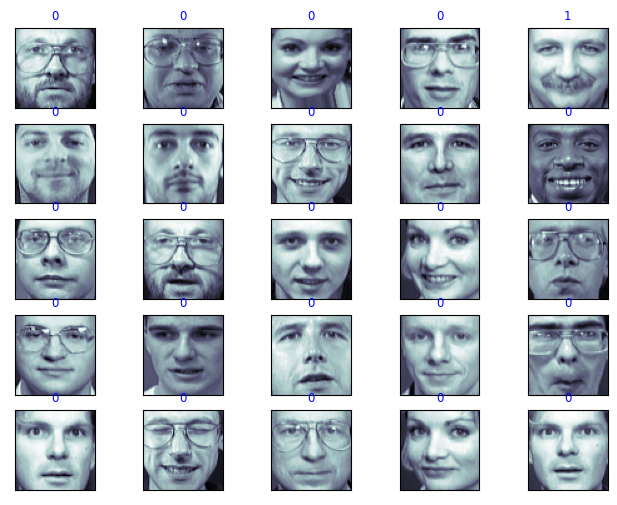

In [508]:
# Lets look for person number 24
person_to_find = 24
y_train_new = (y_train == person_to_find).astype(int) # Class 1 of you are the person we are looking for
y_test_new = (y_test == person_to_find).astype(int)   # Must be done on both label sets
X_test_pca = pca.transform(X_test)

clf = svm.SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train_new)

fig = plt.figure(figsize=(8, 6))
for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape(faces.images[0].shape),
              cmap=plt.cm.bone)
    y_pred = clf.predict(X_test_pca[i, np.newaxis])[0]
    color = ('blue' if y_pred == y_test_new[i] else 'red') # Use the new labels when coloring
    ax.set_title(y_pred, fontsize='small', color=color)

plt.show()

Lets have a look at its accuracy as well.

In [509]:
clf = svm.SVC(C=6, gamma=0.001, kernel='rbf', degree=4)
clf.fit(X_train_pca, y_train_new)

y_pred = clf.predict(X_test_pca)
print('Accuracy: ', accuracy_score(y_test_new, y_pred))

Accuracy:  1.0


Not surprisingly, it is easier to answer "Is this a picture of person X", than to answer "Who is this a picture of?".